In [1]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# Data Import Functions
def import_train_csvs() -> pd.DataFrame:
    # Read train-X.csv, combine and return df 
    col_names = ['index','movie_id','primaryTitle','originalTitle','startYear','endYear','runtimeMinutes','numVotes','label']
    train_df = pd.DataFrame(columns=col_names)
    for i in range(1, 9):
        auxilliary_df = pd.read_csv(filepath_or_buffer=f'./imdb/train-{i}.csv',
                                    header=0,
                                    names=col_names,
                                    na_values='\\N')
        train_df = pd.concat([train_df, auxilliary_df])
     
    return train_df

def import_hidden_csv(filename: str) -> pd.DataFrame:
    # Read the validation-hidden.csv and return df
    col_names = ['index','movie_id','primaryTitle','originalTitle','startYear','endYear','runtimeMinutes','numVotes']
    hidden_df = pd.read_csv(filepath_or_buffer=f'./imdb/{filename}', 
                                header=0,
                                names=col_names,
                                na_values='\\N')
    return hidden_df

def import_directors() -> pd.DataFrame:
    # Read directors from .json file and return df
    directors_df = pd.read_json('./imdb/directing.json')
    directors_df.columns = ['movie_id', 'director_id']
    return directors_df

def import_writers() -> pd.DataFrame:
    # Read writers from .json file and return df
    writers_df = pd.read_json('./imdb/writing.json')
    writers_df.columns = ['movie_id', 'writer_id']
    return writers_df

/var/folders/pv/ng4pj3dx1lzdf21rlczf5b900000gn/T/ipykernel_19911/4092653553.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, auxilliary_df])


        movie_id   writer_id
0      tt0003740   nm0195339
1      tt0003740   nm0515385
2      tt0003740   nm0665163
3      tt0003740   nm0758215
4      tt0008663   nm0406585
...          ...         ...
22381  tt9690328   nm4363465
22388  tt9735790   nm2325602
22395  tt9769668  nm10470070
22396  tt9769668  nm13058768
22406  tt9812614   nm0845618

[2135 rows x 2 columns]


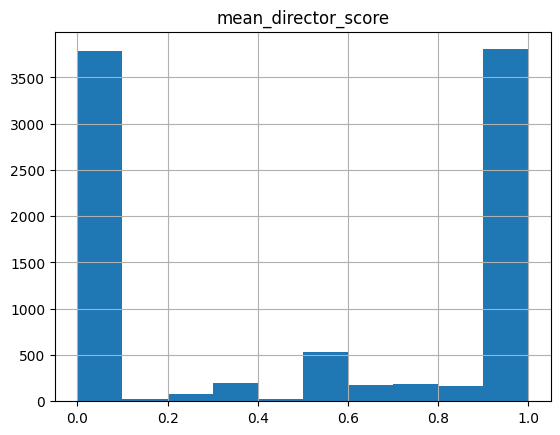

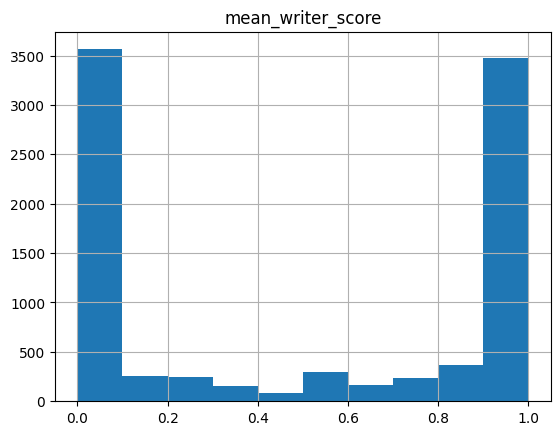

In [3]:
# Data Import
train_df = import_train_csvs()
directors_df = import_directors()
writers_df = import_writers()
validation_df = import_hidden_csv(filename='validation_hidden.csv')

print(writers_df[writers_df['movie_id'].isin(validation_df['movie_id'])])

## Preprocessing for train_df ##
# New releaseDate column
train_df['releaseDate'] = train_df.apply(lambda row: row['endYear'] if row['startYear'] == "\\N" else row['startYear'], axis=1)

# Drop unused columns
train_df = train_df.drop(columns=["startYear", "endYear", 'index'])

# Impute NA values in numVotes, runtimeMinutes and releaseDate columns
mean_numVotes = int(train_df['numVotes'].mean())
mean_runtimeMinutes = int(train_df['runtimeMinutes'].mean())
mean_releaseDate = int(train_df['releaseDate'].mean())
train_df['numVotes'] = train_df['numVotes'].fillna(mean_numVotes)
train_df['runtimeMinutes'] = train_df['runtimeMinutes'].fillna(mean_runtimeMinutes)
train_df['releaseDate'] = train_df['releaseDate'].fillna(mean_releaseDate)

# encode True/False labels to 1/0 values
train_df['label'] = train_df['label'].apply(lambda x: 1 if x else 0)

# Set correct dtypes
train_df['releaseDate'] = train_df['releaseDate'].astype('int')
train_df['runtimeMinutes'] = train_df['runtimeMinutes'].astype('int')

## Feature engineering for directors_df ##
# Idea: for each movie record its label. Based on the labels, create a df with a mean label for each director

# Merge directors_df and training labels
directors_df = directors_df.merge(train_df[['movie_id', 'label']], on='movie_id', how='left')

# Drop rows with missing director_id values
directors_df = directors_df[directors_df['director_id']!='\\N']

# Calculate mean label value for each director
mean_label_per_director = directors_df.groupby('director_id')['label'].mean().reset_index()

# Merge mean_label_per_director with the original DataFrame on director_id
director_scores_df = directors_df.merge(mean_label_per_director, on='director_id', suffixes=('', '_mean_director'))

# Group by movie_id and calculate the mean of mean label per director for each movie
director_scores_df = director_scores_df.groupby('movie_id')['label_mean_director'].mean().reset_index()
director_scores_df.columns = ['movie_id', 'mean_director_score']

# Output the result
director_scores_df.hist()
plt.show()

## Feature engineering for the writers_df ## 
# Idea: for each movie record its label. Based on the labels, create a df with a mean label for each writer
# Merge directors_df and training labels
writers_df = writers_df.merge(train_df[['movie_id', 'label']], on='movie_id', how='left')

# Drop rows with missing director_id values
writers_df = writers_df[writers_df['writer_id']!='\\N']

# Calculate mean label value for each director
mean_label_per_writer = writers_df.groupby('writer_id')['label'].mean()

# Merge mean_label_per_director with the original DataFrame on director_id
writer_scores_df = writers_df.merge(mean_label_per_writer, on='writer_id', suffixes=('', '_mean_writer'))

# Group by movie_id and calculate the mean of mean label per director for each movie
writer_scores_df = writer_scores_df.groupby('movie_id')['label_mean_writer'].mean().reset_index()
writer_scores_df.columns = ['movie_id', 'mean_writer_score']

# Output the result
writer_scores_df.hist()
plt.show()

## Append features to train_df
train_df = train_df.merge(director_scores_df, on='movie_id', how='left')
train_df = train_df.merge(writer_scores_df, on='movie_id', how='left')
# Fill NA values
mean_director_score = director_scores_df['mean_director_score'].mean()
mean_writer_score = writer_scores_df['mean_writer_score'].mean()
train_df['mean_director_score'] = train_df['mean_director_score'].fillna(mean_director_score)
train_df['mean_writer_score'] = train_df['mean_writer_score'].fillna(mean_writer_score)


In [4]:
# Selecting X and y from train_df
X = train_df.drop(columns=['movie_id', 'primaryTitle', 'originalTitle', 'label'])
y = train_df['label']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define hyperparameters grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Instantiate XGBoost with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)

# Train the model with the best parameters
best_xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9824120603015075


In [5]:
## Pre-processing for Validation and Test Set ##
def preprocess_hidden(df: pd.DataFrame, director_scores: pd.DataFrame, writer_scores: pd.DataFrame, 
                      mean_num_votes: int, mean_runtime_minutes: int, mean_release_date: int) -> pd.DataFrame:
    # New releaseDate column
    df['releaseDate'] = df.apply(lambda row: row['endYear'] if row['startYear'] == "\\N" else row['startYear'], axis=1)

    # Drop unused columns
    df = df.drop(columns=["startYear", "endYear", 'index'])
    
    # Impute NA values in numVotes, runtimeMinutes and releaseDate columns
    df['numVotes'] = df['numVotes'].fillna(mean_num_votes)
    df['runtimeMinutes'] = df['runtimeMinutes'].fillna(mean_runtime_minutes)
    df['releaseDate'] = df['releaseDate'].fillna(mean_release_date)
    
    # Append director & writer scores
    df = df.merge(director_scores, on='movie_id', how='left')
    df = df.merge(writer_scores, on='movie_id', how='left')
    
    # Fill NA values with average values
    mean_director_score = director_scores['mean_director_score'].mean()
    mean_writer_score = writer_scores['mean_writer_score'].mean()
    df['mean_director_score'] = df['mean_director_score'].fillna(mean_director_score)
    df['mean_writer_score'] = df['mean_writer_score'].fillna(mean_writer_score)
    
    # Drop un-used columns
    df = df.drop(columns=["movie_id", "primaryTitle", "originalTitle"])
    
    return df

In [7]:
## Validation and Test Set Prediction ##
# Import dataset
validation_df = import_hidden_csv(filename='validation_hidden.csv')
test_df = import_hidden_csv(filename='test_hidden.csv')
print(validation_df.shape)

# Pre-processing 
val_df = preprocess_hidden(validation_df, director_scores=director_scores_df, writer_scores=writer_scores_df,
                           mean_num_votes=mean_numVotes, mean_release_date=mean_releaseDate, 
                           mean_runtime_minutes=mean_runtimeMinutes)
test_df = preprocess_hidden(test_df, director_scores=director_scores_df, writer_scores=writer_scores_df,
                            mean_num_votes=mean_numVotes, mean_release_date=mean_releaseDate, 
                            mean_runtime_minutes=mean_runtimeMinutes)
print(val_df.shape)
# Predict on validation set with XGBoost
val_pred = best_xgb_model.predict(val_df)

# Predict on test set with XGBoost
test_pred = best_xgb_model.predict(test_df)


(955, 8)
(955, 5)


In [8]:
# Turn predictions into booleans
to_bool = lambda val: val == 1
val_pred = np.array([to_bool(i) for i in val_pred])
test_pred = np.array([to_bool(i) for i in test_pred])

# Export predictions to .csv files
pd.DataFrame(val_pred).to_csv('val_pred.csv', index=False, header=False)
pd.DataFrame(test_pred).to_csv('test_pred.csv', index=False, header=False)